# Saudi Arabia Weather Forecasting:
- Part 1: Forecast a weather temperature in any Saudi city **(Univariate time series forecasting).**

_Auther: Esraa Madi_


-------

In [ ]:
# import libs
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
def plot_series(time, series, fig_title, x_label="Time", y_label="Value", format="-", start=0, end=None):
    """Function to plot time series data"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(fig_title)
    plt.grid(True)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# load cleaned data 
infile = open('/content/gdrive/My Drive/Colab Notebooks/datasets/clean_cities_dataset','rb')
df_cities_lst = pickle.load(infile)
cities = pickle.load(infile)
infile.close()

In [ ]:
# show some data
df_cities_lst[0].head()

,barometer,humidity,temp,visibility,wind,city,weather
2017-01-01 00:00:00,1018.0,64.0,17.0,16.0,11.0,Qassim,Clear
2017-01-01 03:00:00,1018.0,64.0,17.0,16.0,11.0,Qassim,Clear
2017-01-01 06:00:00,1018.0,64.0,17.0,16.0,11.0,Qassim,Clear
2017-01-01 09:00:00,1018.0,64.0,17.0,16.0,11.0,Qassim,Clear
2017-01-01 12:00:00,1018.0,64.0,17.0,16.0,11.0,Qassim,Clear


In [ ]:
# Saudi cities
cities

['Qassim',
 'Hail',
 'Madina',
 'EP',
 'Riyadh',
 'Mecca',
 'Tabuk',
 'Assir',
 'Northern boarder',
 'Jazan',
 'Najran',
 'Baha',
 'Jawf']

In [ ]:
# let's start by forcastion temperature of Madina city
city_index = cities.index('Madina')
city_index

2

In [ ]:
# number of rows we have for Madina
df_cities_lst[city_index].shape

(6793, 7)

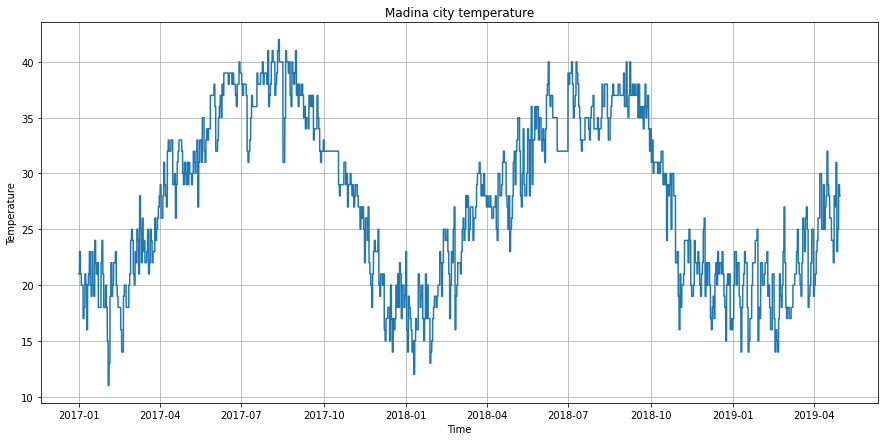

In [ ]:
# plot Madina tempruture
series = df_cities_lst[city_index].temp.values
time = np.array(df_cities_lst[2].index)
plt.figure(figsize=(15, 7))
plot_series(time, series, fig_title="Madina city temperature", y_label="Temperature")

In [ ]:
# split our data to train and text data
split_time = 4700 # where test data starts
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# number of features (points) used to predict next point after this window
window_size = 64

# For training we need to create batches (set of rows(X) with corresponding y)
batch_size = 256

# It will just fill the buffer with the first 'shuffle_buffer_size' elements, pick one of them at random. 
# And then it will replace that with the 'shuffle_buffer_size' element and first element before randomly picking again, and so on. 
# using a shuffle buffer speeds things up a bit.
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    '''Function used to divide our series to windows since each window contains number of points
       we will consider then as features to predict the next value after this window'''

    # inserts a dimension of 1 at the dimension index axis (-1 means last index)of input's shape 
    # so here if series [1, 2, 3, 4] with shape [4] , so the result is [[1], [2], [3], [4]] with shape [6,1]
    series = tf.expand_dims(series, axis=-1)

    # create a dataset from the series using a tf.data dataset.
    ds = tf.data.Dataset.from_tensor_slices(series)

    # convert series to following form:
    # row1: 0-30 points 
    # row2: 1-31 points 
    # row3: 2-32 points and so on
    # every time we shift by one point 
    # here it add 1 to window size bcz (feature num + label)
    # drop_remainder: is useful at the end to delete last rows that don't have enough features 
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

    # put these windows into numpy lists so that we can start using them with machine learning.
    # ex :
    # row1 (window1): 1 2 3 4 5 => [1 2 3 4 5]
    # row2 (window2): 2 3 4 5 6 => [2 3 4 5 6] and so on
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    # shuffle our data (rows) before training.
    ds = ds.shuffle(shuffle_buffer)

    # divide each row to 'window_size' as features and 1 as lebal
    # ex:
    # row1: [1 2 3 4 5] => [1 2 3 4] [5]
    ds = ds.map(lambda w: (w[:-1], w[1:]))

    # batch the data into sets of 'batch_size'
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    """Function to divide series to windows then forcast next values for each window in a series data"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
# clear tensorflow session
tf.keras.backend.clear_session()

# Setting seed to ensure reproducibility.
tf.random.set_seed(51)
np.random.seed(51)

# preprocess series data
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4700,)


In [ ]:
# Build deep learning model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
  # The default activation function in the RNN layers is tan H which is the hyperbolic tangent activation. 
  # This outputs values between negative one and one. Since the time series values are in that order usually in 
  # the 10s like 40s, 50s, 60s, and 70s, then scaling up the outputs to the same ballpark can help us with learning
])

# change learning rate during training
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
# set optimizer
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# compile and fit model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
19/19 [==============================] - 1s 57ms/step - loss: 45.8426 - mae: 46.3405 - lr: 1.0000e-08
Epoch 2/100
19/19 [==============================] - 1s 61ms/step - loss: 41.6222 - mae: 42.1194 - lr: 1.1220e-08
Epoch 3/100
19/19 [==============================] - 1s 62ms/step - loss: 34.8994 - mae: 35.3963 - lr: 1.2589e-08
Epoch 4/100
19/19 [==============================] - 1s 63ms/step - loss: 26.5995 - mae: 27.0975 - lr: 1.4125e-08
Epoch 5/100
19/19 [==============================] - 1s 60ms/step - loss: 19.5252 - mae: 20.0236 - lr: 1.5849e-08
Epoch 6/100
19/19 [==============================] - 1s 59ms/step - loss: 13.3053 - mae: 13.8021 - lr: 1.7783e-08
Epoch 7/100
19/19 [==============================] - 1s 59ms/step - loss: 8.2449 - mae: 8.7338 - lr: 1.9953e-08
Epoch 8/100
19/19 [==============================] - 1s 62ms/step - loss: 5.8437 - mae: 6.3205 - lr: 2.2387e-08
Epoch 9/100
19/19 [==============================] - 1s 60ms/step - loss: 5.4819 - mae: 5.96

(1e-08, 0.0001, 0.0, 60.0)

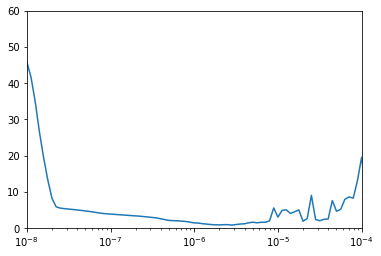

In [ ]:
# plot learning rate to pick next start point for lr
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
# forcast weather temperature using above model

# np.newaxis reshapes data to the input dimension that's used by the model
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# split_time - window_size:-1 => we forcasted whole data, so need to just pick valid data 
# -1 => it's repeated as window size, just get last value to be label
# 0 => convert [23] to 23
rnn_forecast_ = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
# check sum shapes
print('input data shape: ', series[..., np.newaxis].shape)
print('forcasted data shape: ', rnn_forecast.shape)
print('forcasted data after fixing shape: ', rnn_forecast_.shape)

input data shape:  (6793, 1)
forcasted data shape:  (6730, 64, 1)
forcasted data after fixing shape:  (2093,)


In [ ]:
# show forcasted result
print(rnn_forecast_)

[-210.0024 -210.0024 -210.0024 ... -210.0024 -210.0024 -210.0024]


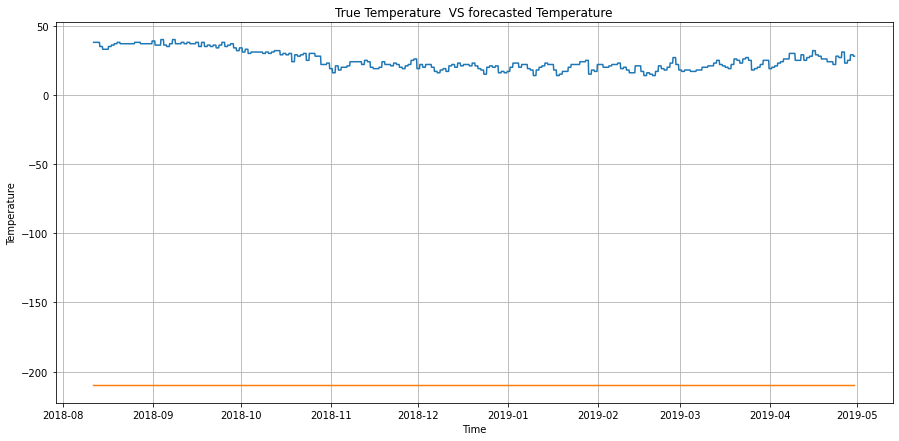

In [ ]:
# plot forcasting data
plt.figure(figsize=(15, 7))
plot_series(time_valid, x_valid, fig_title="True Temperature  VS forecasted Temperature", y_label='Temperature')
plot_series(time_valid, rnn_forecast_, fig_title="True Temperature  VS forecasted Temperature", y_label='Temperature')

In [ ]:
# we'll use best learning rate from figure above to build better model
# prepare new model
tf.keras.backend.clear_session()

# prepare data
window_size = 60
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# build new model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
47/47 [==============================] - 1s 32ms/step - loss: 12.3137 - mae: 12.8015
Epoch 2/150
47/47 [==============================] - 2s 33ms/step - loss: 2.3178 - mae: 2.7832
Epoch 3/150
47/47 [==============================] - 2s 32ms/step - loss: 2.1997 - mae: 2.6698
Epoch 4/150
47/47 [==============================] - 2s 32ms/step - loss: 1.9561 - mae: 2.4210
Epoch 5/150
47/47 [==============================] - 2s 32ms/step - loss: 3.3869 - mae: 3.8593
Epoch 6/150
47/47 [==============================] - 2s 32ms/step - loss: 2.7484 - mae: 3.2096
Epoch 7/150
47/47 [==============================] - 2s 33ms/step - loss: 1.7753 - mae: 2.2374
Epoch 8/150
47/47 [==============================] - 2s 32ms/step - loss: 4.3081 - mae: 4.7804
Epoch 9/150
47/47 [==============================] - 2s 33ms/step - loss: 4.7239 - mae: 5.2109
Epoch 10/150
47/47 [==============================] - 1s 32ms/step - loss: 5.0797 - mae: 5.5623
Epoch 11/150
47/47 [===========================

In [ ]:
# forcast weather temperature using above model

# np.newaxis reshapes data to the input dimension that's used by the model
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast_ = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
print(rnn_forecast_)

[37.94281  37.929653 37.930603 ... 28.372293 27.874767 27.79946 ]


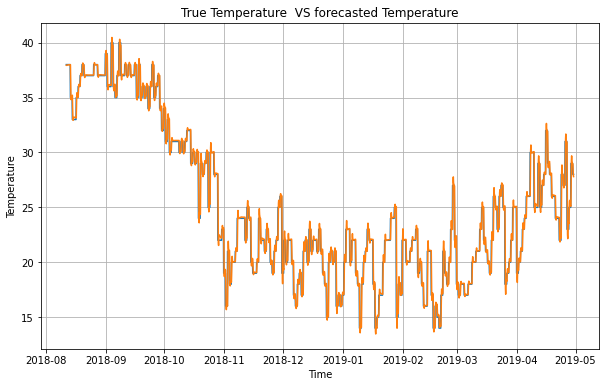

In [ ]:
# plot forcasting data
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, fig_title="True Temperature  VS forecasted Temperature", y_label='Temperature')
plot_series(time_valid, rnn_forecast_, fig_title="True Temperature  VS forecasted Temperature", y_label='Temperature')

In [ ]:
# loss/error
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast_).numpy()

0.44035494

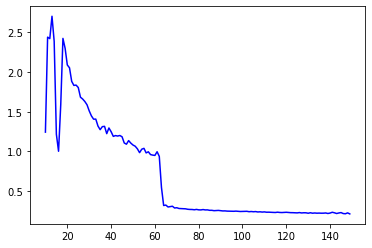

In [ ]:
# Plot loss starting from 10th loss
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()